Data collection  will be demonstrated in this notebook. We will first install and import the necessary packages to proceed with gathering our data.

#Importing packages

In [ ]:
!pip install yfinance
!pip install pandas-datareader
!pip install --upgrade pandas-datareader
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

#1. Load the S&P Cryptocurrency BDM Index from a CSV file

*Bloomberg Ticker : SPCBDM*

The [S&P Cryptocurrency Broad Digital Market Index](https://www.spglobal.com/spdji/en/indices/digital-assets/sp-cryptocurrency-broad-digital-market-index/#overview) is a market-cap-weighted index that tracks the performance of digital assets listed on recognized open digital exchanges that meet minimum liquidity and market capitalization criteria that are covered by Lukka.

The index is meant to reflect a broad investable universe. The index was launched in July 2021 and includes more than 240 coins at launch. The index is rebalanced quarterly and the constituents are selected based on a variety of factors, including liquidity, market capitalization, and trading volume.

The S&P Cryptocurrency BDM Index is a useful tool for investors who want to track the performance of the cryptocurrency market as a whole. It can also be used to compare the performance of different cryptocurrencies against each other.

In [ ]:
# Load the S&P Cryptocurrency BDM Index data
Crypto = pd.read_csv('/content/PerformanceGraphExport2.csv')

#2. Download data from Yahoo Finance

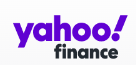

In this section, we will utilise the powerful yfinance plugin to download data for the S&P500 index and selected exchange rates (GBP/JPY, EUR/CAD, AUD/CNY).

In [ ]:
# Download S&P500 data using yfinance
sp500_data = yf.download('^GSPC', start='2017-02-01', end='2023-05-01')
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# Extract the 'Close' prices
sp500_close = sp500_data['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Download the exchange rates data using yfinance
tickers = ['GBPJPY=X', 'EURCAD=X', 'AUDCNY=X']
FX_rates = yf.download(tickers, start='2017-02-01', end='2023-05-01')
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

[*********************100%***********************]  3 of 3 completed


In [ ]:
# Extract the 'Close' prices
GBP_JPY = FX_rates['Close']['GBPJPY=X']
EUR_CAD = FX_rates['Close']['EURCAD=X']
AUD_CNY = FX_rates['Close']['AUDCNY=X']

In [ ]:
# Merge the S&P500 data with Exchange rates data based on the date index
merged_data = pd.merge(sp500_close, GBP_JPY, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, EUR_CAD, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, AUD_CNY, left_index=True, right_index=True)

In [ ]:
# Merge the previous data from yfinance and the S&P Cryptocurrency BDM Index data based on date
Crypto['Date'] = pd.to_datetime(Crypto['Date'])
Crypto.set_index('Date', inplace=True)
merged_data = pd.merge(merged_data, Crypto, left_index=True, right_index=True)

#3. Download short-term interest rates and inflation data from FRED:
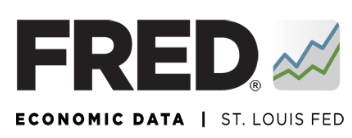

FRED is a database of more than 800,000 economic data series from over 100 sources covering issues and information relating to banking, business, consumer and producer price indices, employment, population, exchange rates, gross domestic product, interest rates, trade and international transactions, and U.S. financial data. FRED provides data and data services to the public for non-commercial, educational, and personal uses subject to a few prohibitions.

[3-Month Treasury Bill Secondary Market Rate, Discount Basis](https://fred.stlouisfed.org/series/DTB3)

[Consumer Price Index: Total All Items for the United States](https://fred.stlouisfed.org/series/CPALTT01USM657N)

In [ ]:
Int_rate = pdr.data.DataReader('DTB3', 'fred', start='2017-02-28', end='2023-05-01')
Int_rate.columns = ['Int_rates']
Int_rate = Int_rate.dropna()
Int_rate.tail()

In [ ]:
Inflation = pdr.data.DataReader('CPALTT01USM657N', 'fred', start='2017-02-28', end='2023-05-01')
Inflation.columns = ['Inflation']
Inflation = Inflation.dropna()
Inflation.tail()

Since the CPI data is in monthly frequency, we will need to resample it into daily frequency to match the rest of our variables. In this case, interpolation method was used.

In [ ]:
# Resampling the CPI from annually to daily frequency
Inflation_d = Inflation.resample('D').interpolate(method='linear')
Inflation_d.tail()

#4. Load the Economic Policy Uncertainty (EPU) data from a CSV file

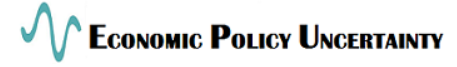

The Economic Policy Uncertainty (EPU) index was developed by Scott R. Baker, Nicholas Bloom, and Steven J. Davis [1](https://www.policyuncertainty.com/about.html). They developed a new method to measure economic policy uncertainty and tested its dynamic relationship with output, investment, and employment. The EPU index is now widely used by policymakers, researchers, and analysts to assess the effects of policy uncertainty on investment decisions, business confidence, and overall economic performance.

[US EPU (Monthly, Daily, Categorical)](https://www.policyuncertainty.com/us_monthly.html)

For this research, we will be using the "News Coverage about Policy-related Economic Uncertainty". It is an index of search results from 10 large newspapers (USA Today, the Miami Herald, the Chicago Tribune, the Washington Post, the Los Angeles Times, the Boston Globe, the San Francisco Chronicle, the Dallas Morning News, the Houston Chronicle, and the WSJ). Monthly searches of each paper for terms related to economic and policy uncertainty were done to construct the index. In particular, the researchers search for articles containing the term 'uncertainty' or 'uncertain', the terms 'economic' or 'economy' and one or more of the following terms: 'congress', 'legislation', 'white house', 'regulation', 'federal reserve', or 'deficit'.

The data was downloaded from the official site and saved as a CSV file. Similarly, upscaling will be performed to match the daily frequency of our dataset.

In [ ]:
# Load the Economic Policy Uncertainty (EPU) data
EPU = pd.read_csv('/content/US_Policy_Uncertainty_Data2.csv')
EPU['Date'] = pd.to_datetime(EPU['Date'])
EPU.set_index('Date', inplace=True)
EPU = EPU.dropna()

# Resampling the EPU index from monthly to daily frequency
EPU_d = EPU.resample('D').interpolate(method='linear')
EPU_d.tail

#5. Merge all variables into one data frame

In [ ]:
# Merge the new variables into our data frame
merged_data = pd.merge(merged_data, Int_rate, left_index=True, right_index=True, suffixes=('_merged', '_Int_rate'))
merged_data = pd.merge(merged_data, Inflation_d, left_index=True, right_index=True, suffixes=('_merged', '_Inflation_d'))
merged_data = pd.merge(merged_data, EPU_d, left_index=True, right_index=True, suffixes=('_merged', '_EPU_d'))
merged_data.tail()

,Close,GBPJPY=X,EURCAD=X,AUDCNY=X,S&P Cryptocurrency Broad Digital Market Index (USD),Int_rates,Inflation,News_Based_Policy_Uncert_Index
2023-04-24,4137.040039,166.729996,1.48770,4.607537,2114.64,5.04,0.311124,195.666667
2023-04-25,4071.629883,167.584000,1.49634,4.616732,2124.01,4.97,0.302656,197.000000
2023-04-26,4055.989990,165.977005,1.49497,4.593824,2130.29,5.00,0.294187,198.333333
2023-04-27,4135.350098,166.410004,1.50546,4.573267,2249.02,5.03,0.285718,199.666667
2023-04-28,4169.479980,167.070007,1.50020,4.585211,2218.22,4.95,0.277250,201.000000


In [ ]:
# Save file to csv
merged_data.to_csv('merged_data_with_datetime.csv')